In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
import time

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import make_pipeline

# **Regression Model Comparison Template** 
This Notebook compares the performance of different types of regression models on a dataset provided by the user. It is meant to assist in the model selection process, helping users discern the most suitible regression technique for their dataset. Users should store data in the data directory.
### **Regression Analysis**
Regression refers to statistical methods for analyzing the relationship between dependent and independent variables. In machine learning, regression analysis is implimented as supervised learning algorithms used to identify the relationships between dependent variables called targets and predictive independent variables called features. Understanding this relationship 

In this example, the regression models are evaluated on a real world dataset on California housing. 

In [45]:
california_housing = fetch_california_housing(as_frame = True)
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [46]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=DM+Sans:ital,opsz,wght@0,9..40,100..1000;1,9..40,100..1000&display=swap');
div.text_cell {font-family : DM Sans, sans-serif !important;}
pre {font-family : DM Sans, sans-serif !important;}
</style>

In [47]:
DATA_FILE_NAME: str = "" 
TARGET_COLUMN_NAME: str = ""
TARGET_VARIABLE_NAME: str = "MedHouseVal"
NUM_DECIMAL_PLACES: int = 5
TABLE_FONT_SIZE: int = 16 #px

## Loading in a Dataset and Handling Missing Values

In [48]:
def load_data(data_file_name: str = DATA_FILE_NAME, target_column_name: str = TARGET_COLUMN_NAME) -> tuple:
    """
    Loads in user's input file as a pandas DataFrame and cleans the data by dropping duplicate rows and removing rows with any missing values.
    
     Args:
        file_name (str): Name of file containing data for training and testing the models
        target_column_name (str): Name of the column containing your dataset's target variable
    Returns:
        tuple: Tuple contains a dataframe with feature data entries and a series with ccorresponding target entries
    """
    # Add df editing interface for dropping unwanted columns
    
    file_name = "data/" + file_name
    file_extension = file_name.split(".")[-1]

    if file_extension == "csv":
        df = pd.read_csv(file_name)
    elif file_extension in ["xls", "xlsx"]:
        df = pd.read_excel(file_name)
    elif file_extension == "json":
        df = pd.read_json(file_name)
    else:
        raise ValueError("Unsupported file format. Please upload a CSV, Excel, or JSON file.")
    
    df.drop_duplicates(inplace = True)
    df.dropna(inplace = True)
    
    clean_feature_values_df = df.drop(columns = target_column_name)
    clean_target_values_series = df[target_column_name]
    return (clean_feature_values_df, clean_target_values_series)

#feature_values_df, target_values_series = load_data()
#feature_values_df.head()

In [49]:
# Load in sk-learn regression feature and target data
feature_values_df = california_housing.data
target_values_series = california_housing.target

# Currently handling missing values by dropping rows with any values missing. There are better ways to do this.
clean_features_df = feature_values_df.drop_duplicates()
clean_features_df.dropna(inplace = True)
clean_targets_df = target_values_series

In [50]:
FEATURE_LIST = list(feature_values_df.columns)
NUM_FEATURES = len(FEATURE_LIST)

## Data Preprocessing and Model Training


In [51]:
# List containing 100 equally spaced floats between 0.01 and 100
alpha_values = np.linspace(0.01, 100, num = 100)

models = {
    'Linear': {
        'model': make_pipeline(StandardScaler(), LinearRegression()),
        'param_grid': {}  
    },
    'Lasso': {
        'model': make_pipeline(StandardScaler(), Lasso()),
        'param_grid': {'lasso__alpha': alpha_values}
    },
    'Ridge': {
        'model': make_pipeline(StandardScaler(), Ridge()),
        'param_grid': {'ridge__alpha': alpha_values}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state = 42), 
        'param_grid': {}
    },
    'SVR': { 
        'model': make_pipeline(StandardScaler(), SVR()),
        'param_grid': {}
    }
}

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
results = {}

print("Start")
for model_name, model_data in models.items():
    # Imporve training time metrics
    print(f"Training and evaluating: {model_name}") 

    model = model_data['model']
    param_grid = model_data['param_grid']

    grid_search = GridSearchCV(model, param_grid, cv = kf, scoring = 'neg_mean_squared_error')
    grid_search.fit(clean_features_df, clean_targets_df)

    best_model = grid_search.best_estimator_

    results[model_name] = {
        'best_model': best_model,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

    all_test_mse = []
    all_y_test = []
    all_y_test_predictions = []
    all_X_train = []
    all_y_train = []

    for i, (train_index, test_index) in enumerate(kf.split(clean_features_df)):
        X_train, X_test = clean_features_df.iloc[train_index], clean_features_df.iloc[test_index]
        y_train, y_test = clean_targets_df.iloc[train_index], clean_targets_df.iloc[test_index]

        y_test_prediction = best_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_prediction) 
        
        all_test_mse.append(test_mse)
        all_y_test.append(y_test)
        all_y_test_predictions.append(y_test_prediction)
        all_X_train.append(X_train)
        all_y_train.append(y_train)
        
        if model_name in ['Linear', 'Lasso', 'Ridge']:
            results[model_name]["intercept"] = best_model[-1].intercept_
            results[model_name]["coefficients"] = best_model[-1].coef_


    median_test_mse = np.median(all_test_mse)
    median_fold_indices = np.where(all_test_mse == median_test_mse)[0]
    median_fold_index = median_fold_indices[0]
    median_X_train = all_X_train[median_fold_index]
    median_y_train = all_y_train[median_fold_index]
    median_y_test =  all_y_test[median_fold_index]
    median_y_test_predictions = all_y_test_predictions[median_fold_index]
    
    results[model_name]['median_fold_index'] = median_fold_index
    results[model_name]['median_X_train'] = median_X_train
    results[model_name]['median_y_train'] = median_y_train
    results[model_name]['median_y_test'] = median_y_test
    results[model_name]['median_y_test_predictions'] = median_y_test_predictions
    
    best_model.fit(median_X_train, median_y_train)
    median_y_train_predictions = best_model.predict(median_X_train)
    
    median_train_mse = mean_squared_error(median_y_train, median_y_train_predictions)
    median_mse = mean_squared_error(median_y_test, median_y_test_predictions)
    median_mae = mean_absolute_error(median_y_test, median_y_test_predictions)
    median_r2 = r2_score(median_y_test, median_y_test_predictions)
    num_test_entries = len(median_y_test)
    median_adjusted_r2 = 1 - ((1 - median_r2) * (num_test_entries - 1) / (num_test_entries - NUM_FEATURES - 1))
    
    results[model_name]["median_train_mse"] = median_train_mse
    results[model_name]["median_mse"] = median_mse
    results[model_name]["median_mae"] = median_mae
    results[model_name]["median_r2"] = median_r2
    results[model_name]["median_adjusted_r2"] = median_adjusted_r2

print("End")



Start
Training and evaluating: Linear
Training and evaluating: Lasso
Training and evaluating: Ridge
Training and evaluating: Random Forest
Training and evaluating: SVR
End


### Functions for Displaying Data

In [52]:
def create_fit_function_equation_markdown(intercept: int, coefficient_list: list, feature_list: list = FEATURE_LIST, num_decimal_places: int = NUM_DECIMAL_PLACES) -> str:
    model_equation = f"{TARGET_VARIABLE_NAME} = {intercept:.{num_decimal_places}f}"
    for i in range(len(coefficient_list)):
        model_equation += f" + {coefficient_list[i]:.{num_decimal_places}f}({feature_list[i]})"
    return model_equation

train_mse_string = "Mean Squared Error on Training Set"
mse_string = "Mean Squared Error on Testing Set"
mae_string = "Mean Absolute Error on Testing Set"
r2_string = "R-Squared Score on Testing Set"
adjusted_r2_string = "Adjusted R-Squared Score on Testing Set"

def create_model_evaluation_table_markdown(train_mse: float, mse_value: float, mae_value: float, r2_value: float, adjusted_r2_value: float, num_decimal_places: int = NUM_DECIMAL_PLACES, table_font_size: int = TABLE_FONT_SIZE) -> str:
    table_font_size_html = f"""
        <style>
        td,th {{
            font-size: {table_font_size}px;
        }}
        </style>"""
    final_loss_string = f"{scoring_function} on Training Set"
    metrics_table_string = f'''| Metric | Value |
                               |:---------:|:-------------:|
                               | {final_loss_string} | {train_mse:.{num_decimal_places}f} |
                               | {mse_string} | {mse_value:.{num_decimal_places}f} |
                               | {mae_string} | {mae_value:.{num_decimal_places}f} |
                               | {r2_string} | {r2_value:.{num_decimal_places}f} |
                               | {adjusted_r2_string} | {adjusted_r2_value:.{num_decimal_places}f} |'''
    metrics_table_markdown = f"{table_font_size_html}{metrics_table_string}"
    return metrics_table_markdown


## Individual Model Evaluation and Performance Visualizations
#### Linear Model

In [53]:
linear_median_X_train = results["Linear"]["median_X_train"]
linear_median_y_train = results["Linear"]["median_y_train"]
linear_median_y_test = results["Linear"]["median_y_test"]
linear_median_y_test_predictions = results["Linear"]["median_y_test_predictions"]

linear_train_mse = results["Linear"]["median_train_mse"]
linear_mse = results["Linear"]["median_mse"]
linear_mae = results["Linear"]["median_mae"]
linear_r2 = results["Linear"]["median_r2"]
linear_adjusted_r2 = results["Linear"]["median_adjusted_r2"]

linear_intercept = results["Linear"]["intercept"]
linear_coefficients = results["Linear"]["coefficients"]

In [54]:
linear_equation = create_fit_function_equation_markdown(linear_intercept, linear_coefficients)

linear_train_mse_string = f"{train_mse_string}: {linear_train_mse}"
linear_mse_string = f"{mae_string}: {linear_mse}"
linear_mae_string = f"{mse_string}: {linear_mae}"
linear_r2_string = f"{r2_string}: {linear_r2}"
linear_adjusted_r2_string = f"{adjusted_r2_string}: {linear_adjusted_r2}"

print("Model Equation:")
print(linear_equation)
print()
print(linear_train_mse_string)
print(linear_mse_string)
print(linear_mae_string)
print(linear_r2_string)
print(linear_adjusted_r2_string)

Model Equation:
MedHouseVal = 2.06856 + 0.82962(MedInc) + 0.11875(HouseAge) + -0.26553(AveRooms) + 0.30570(AveBedrms) + -0.00450(Population) + -0.03933(AveOccup) + -0.89989(Latitude) + -0.87054(Longitude)

Mean Squared Error on Training Set: 0.5235381646297241
Mean Absolute Error on Testing Set: 0.5272801453182804
Mean Squared Error on Testing Set: 0.5365036330013772
R-Squared Score on Testing Set: 0.6140235392036836
Adjusted R-Squared Score on Testing Set: 0.6132738883936883


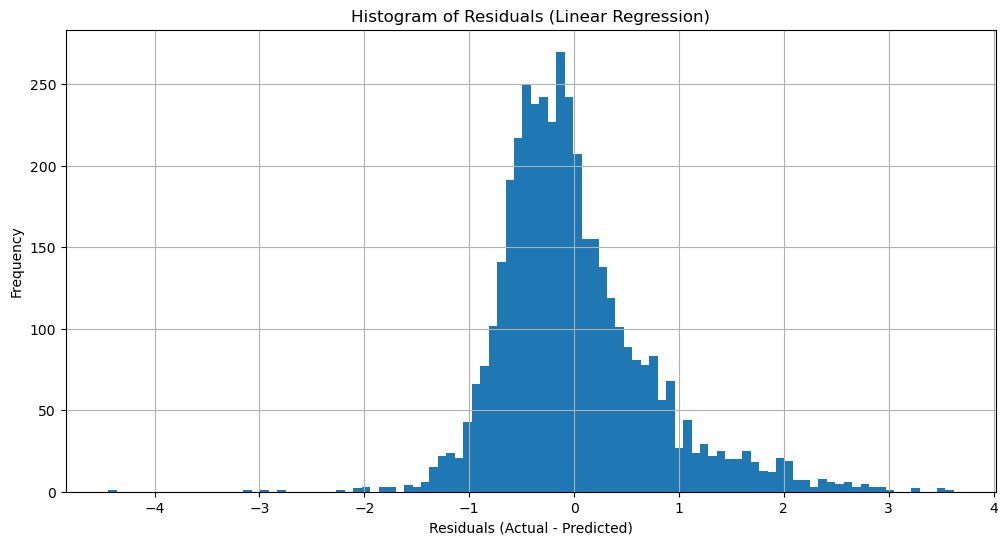

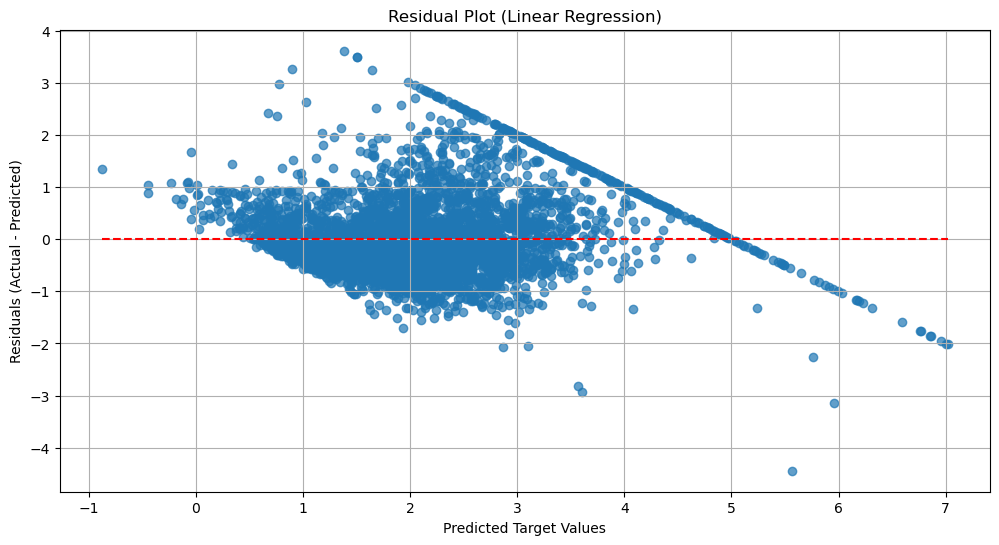

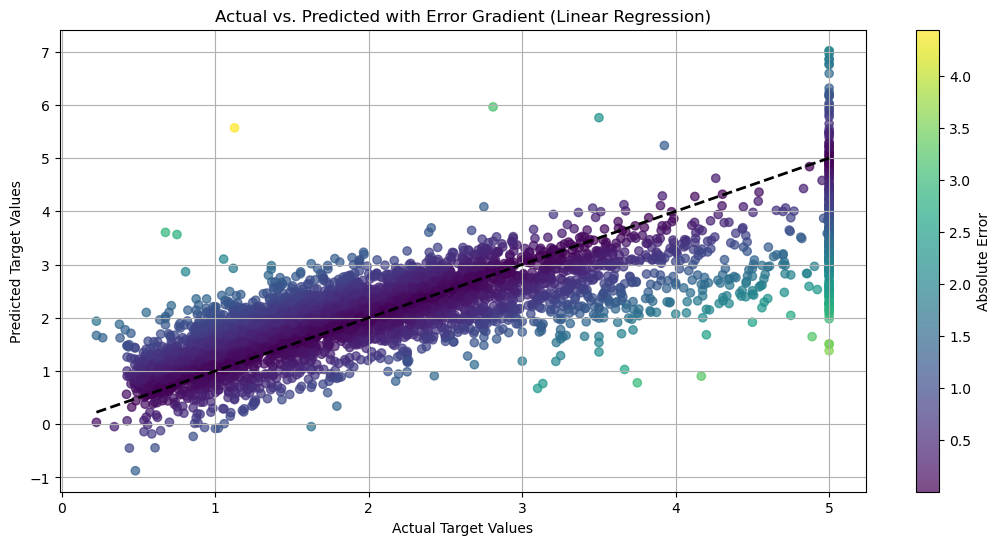

In [55]:
linear_residuals = linear_median_y_test - linear_median_y_test_predictions

plt.figure(figsize = (12, 6))
plt.hist(linear_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Linear Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(linear_median_y_test_predictions, linear_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = linear_median_y_test_predictions.min(), xmax = linear_median_y_test_predictions.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Linear Regression)')
plt.grid(True)
plt.show()

errors = abs(linear_median_y_test - linear_median_y_test_predictions) 
plt.figure(figsize = (13, 6))
plt.scatter(linear_median_y_test, linear_median_y_test_predictions, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([linear_median_y_test.min(), linear_median_y_test.max()], [linear_median_y_test.min(), linear_median_y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Linear Regression)')
plt.grid(True)
plt.show()

#### Lasso Model

In [56]:
lasso_median_X_train = results["Lasso"]["median_X_train"]
lasso_median_y_train = results["Lasso"]["median_y_train"]
lasso_median_y_test = results["Lasso"]["median_y_test"]
lasso_median_y_test_predictions = results["Lasso"]["median_y_test_predictions"]

lasso_train_mse = results["Lasso"]["median_train_mse"]
lasso_mse = results["Lasso"]["median_mse"]
lasso_mae = results["Lasso"]["median_mae"]
lasso_r2 = results["Lasso"]["median_r2"]
lasso_adjusted_r2 = results["Lasso"]["median_adjusted_r2"]

lasso_intercept = results["Lasso"]["intercept"]
lasso_coefficients = results["Lasso"]["coefficients"]

In [57]:
lasso_equation = create_fit_function_equation_markdown(lasso_intercept, lasso_coefficients)

lasso_train_mse_string = f"{train_mse_string}: {lasso_train_mse}"
lasso_mse_string = f"{mse_string}: {lasso_mse}"
lasso_mae_string = f"{mae_string}: {lasso_mae}"
lasso_r2_string = f"{r2_string}: {lasso_r2}"
lasso_adjusted_r2_string = f"{adjusted_r2_string}: {lasso_adjusted_r2}"

print("Model Equation:")
print(lasso_equation)
print()
print(lasso_train_mse_string)
print(lasso_mse_string)
print(lasso_mae_string)
print(lasso_r2_string)
print(lasso_adjusted_r2_string)

Model Equation:
MedHouseVal = 2.06856 + 0.77722(MedInc) + 0.12487(HouseAge) + -0.12941(AveRooms) + 0.16913(AveBedrms) + -0.00000(Population) + -0.02945(AveOccup) + -0.79544(Latitude) + -0.75900(Longitude)

Mean Squared Error on Training Set: 0.529082705638714
Mean Squared Error on Testing Set: 0.5339275998859041
Mean Absolute Error on Testing Set: 0.5409719948519496
R-Squared Score on Testing Set: 0.6091575092382144
Adjusted R-Squared Score on Testing Set: 0.6083984075324378


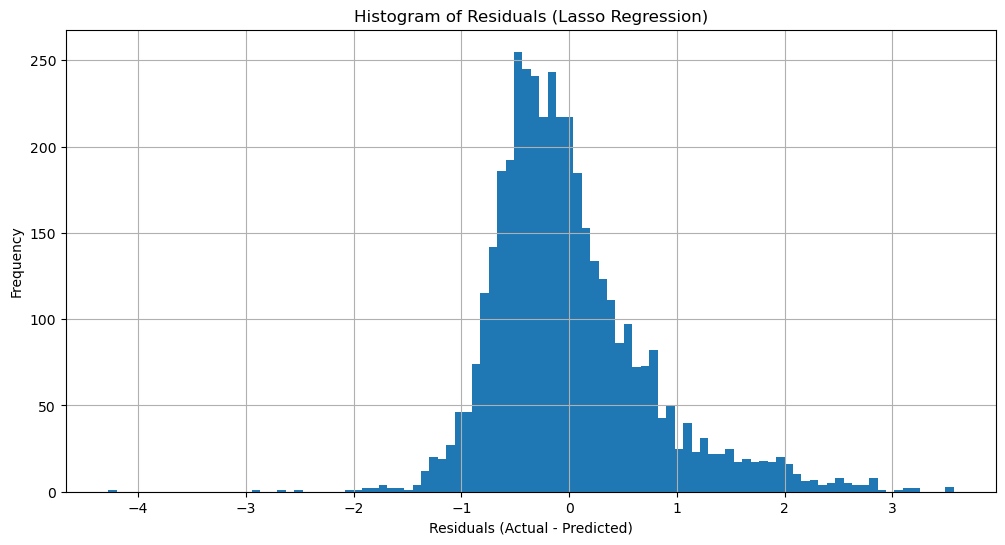

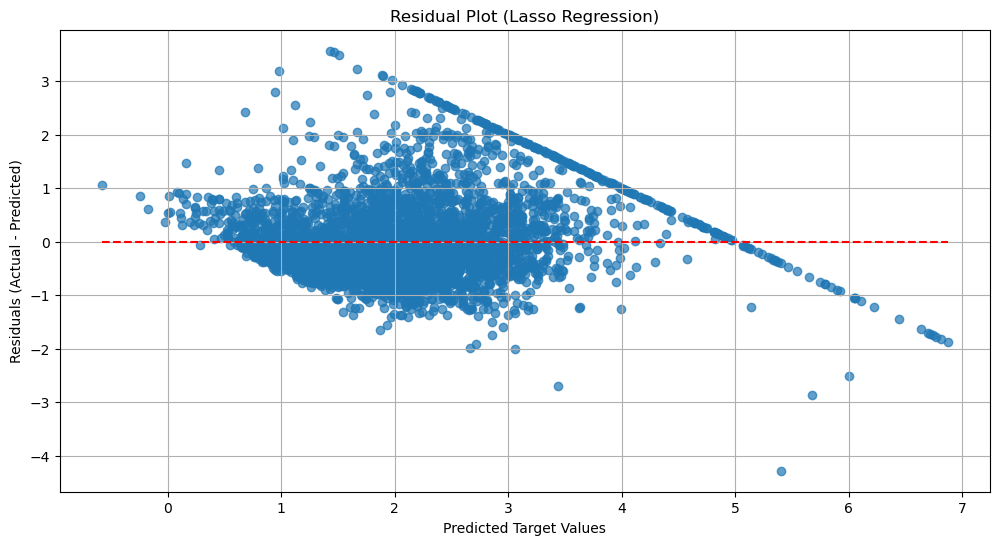

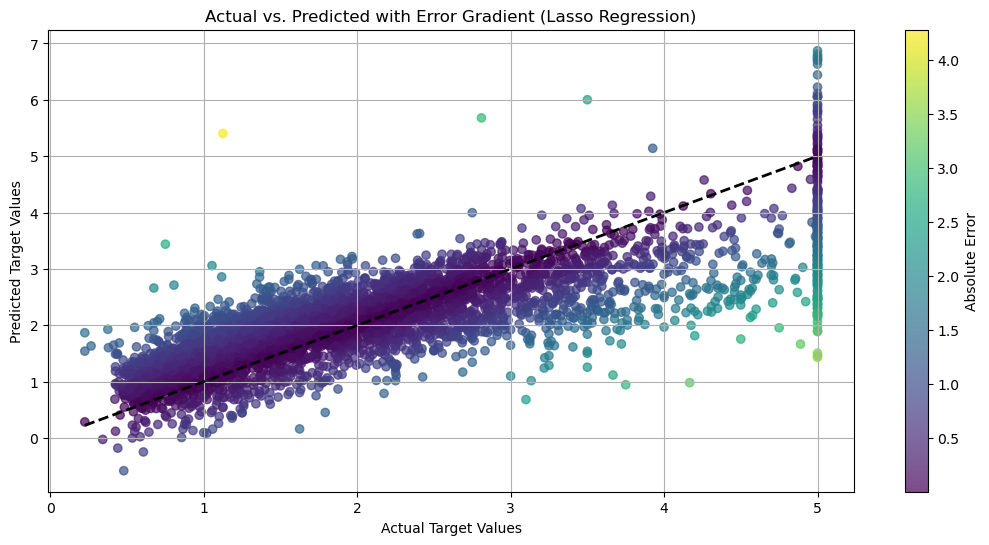

In [58]:
lasso_residuals = lasso_median_y_test - lasso_median_y_test_predictions

plt.figure(figsize = (12, 6))
plt.hist(lasso_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Lasso Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(lasso_median_y_test_predictions, lasso_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = lasso_median_y_test_predictions.min(), xmax = lasso_median_y_test_predictions.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Lasso Regression)')
plt.grid(True)
plt.show()

errors = abs(lasso_median_y_test - lasso_median_y_test_predictions) 
plt.figure(figsize = (13, 6))
plt.scatter(lasso_median_y_test, lasso_median_y_test_predictions, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([lasso_median_y_test.min(), lasso_median_y_test.max()], [lasso_median_y_test.min(), lasso_median_y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Lasso Regression)')
plt.grid(True)
plt.show()

#### Ridge Model

In [59]:
ridge_median_X_train = results["Ridge"]["median_X_train"]
ridge_median_y_train = results["Ridge"]["median_y_train"]
ridge_median_y_test = results["Ridge"]["median_y_test"]
ridge_median_y_test_predictions = results["Ridge"]["median_y_test_predictions"]

ridge_train_mse = results["Ridge"]["median_train_mse"]
ridge_mse = results["Ridge"]["median_mse"]
ridge_mae = results["Ridge"]["median_mae"]
ridge_r2 = results["Ridge"]["median_r2"]
ridge_adjusted_r2 = results["Ridge"]["median_adjusted_r2"]

ridge_intercept = results["Ridge"]["intercept"]
ridge_coefficients = results["Ridge"]["coefficients"]

In [60]:
ridge_equation = create_fit_function_equation_markdown(ridge_intercept, ridge_coefficients)

ridge_train_mse_string = f"{train_mse_string}: {ridge_train_mse}"
ridge_mse_string = f"{mse_string}: {ridge_mse}"
ridge_mae_string = f"{mae_string}: {ridge_mae}"
ridge_r2_string = f"{r2_string}: {ridge_r2}"
ridge_adjusted_r2_string = f"{adjusted_r2_string}: {ridge_adjusted_r2}"

print("Model Equation:")
print(ridge_equation)
print()
print(ridge_train_mse_string)
print(ridge_mse_string)
print(ridge_mae_string)
print(ridge_r2_string)
print(ridge_adjusted_r2_string)

Model Equation:
MedHouseVal = 2.06856 + 0.82902(MedInc) + 0.12011(HouseAge) + -0.26275(AveRooms) + 0.30206(AveBedrms) + -0.00402(Population) + -0.03940(AveOccup) + -0.88696(Latitude) + -0.85749(Longitude)

Mean Squared Error on Training Set: 0.5235778976858008
Mean Squared Error on Testing Set: 0.5273598681544298
Mean Absolute Error on Testing Set: 0.5364769712645119
R-Squared Score on Testing Set: 0.6139651809696123
Adjusted R-Squared Score on Testing Set: 0.6132154168151469


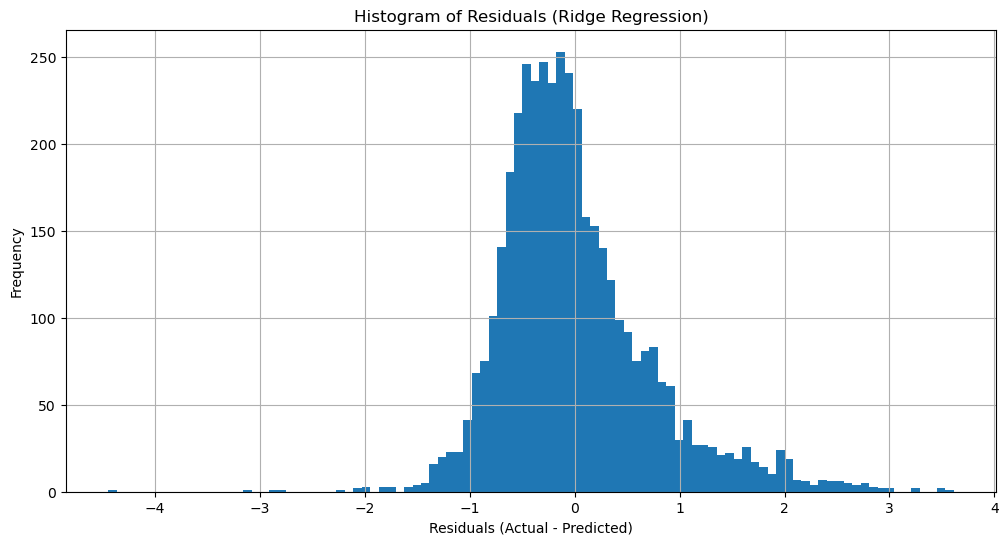

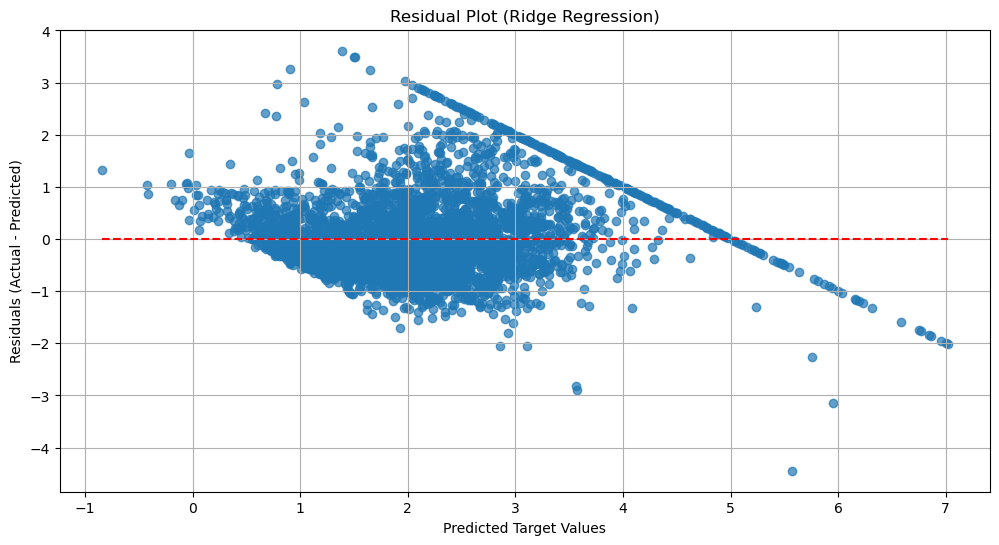

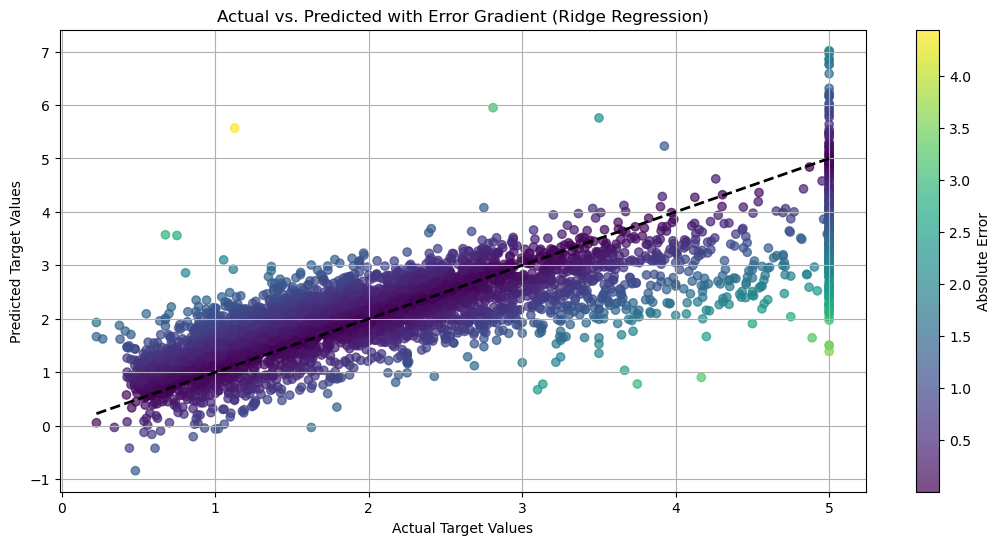

In [61]:
ridge_residuals = ridge_median_y_test - ridge_median_y_test_predictions

plt.figure(figsize = (12, 6))
plt.hist(ridge_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Ridge Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(ridge_median_y_test_predictions, ridge_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = ridge_median_y_test_predictions.min(), xmax = ridge_median_y_test_predictions.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Ridge Regression)')
plt.grid(True)
plt.show()

errors = abs(ridge_median_y_test - ridge_median_y_test_predictions) 
plt.figure(figsize = (13, 6))
plt.scatter(ridge_median_y_test, ridge_median_y_test_predictions, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([ridge_median_y_test.min(), ridge_median_y_test.max()], [ridge_median_y_test.min(), ridge_median_y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Ridge Regression)')
plt.grid(True)
plt.show()

#### Random Forest Model

In [62]:
random_forest_median_X_train = results["Random Forest"]["median_X_train"]
random_forest_median_y_train = results["Random Forest"]["median_y_train"]
random_forest_median_y_test = results["Random Forest"]["median_y_test"]
random_forest_median_y_test_predictions = results["Random Forest"]["median_y_test_predictions"]

random_forest_train_mse = results["Random Forest"]["median_train_mse"]
random_forest_mse = results["Random Forest"]["median_mse"]
random_forest_mae = results["Random Forest"]["median_mae"]
random_forest_r2 = results["Random Forest"]["median_r2"]
random_forest_adjusted_r2 = results["Random Forest"]["median_adjusted_r2"]

In [63]:
random_forest_train_mse_string = f"{train_mse_string}: {random_forest_train_mse}"
random_forest_mse_string = f"{mse_string}: {random_forest_mse}"
random_forest_mae_string = f"{mae_string}: {random_forest_mae}"
random_forest_r2_string = f"{r2_string}: {random_forest_r2}"
random_forest_adjusted_r2_string = f"{adjusted_r2_string}: {random_forest_adjusted_r2}"

print(random_forest_train_mse_string)
print(random_forest_mse_string)
print(random_forest_mae_string)
print(random_forest_r2_string)
print(random_forest_adjusted_r2_string)

Mean Squared Error on Training Set: 0.03582807798298616
Mean Squared Error on Testing Set: 0.035179763562988416
Mean Absolute Error on Testing Set: 0.11992184706879888
R-Squared Score on Testing Set: 0.9742479197211246
Adjusted R-Squared Score on Testing Set: 0.9741979035418988


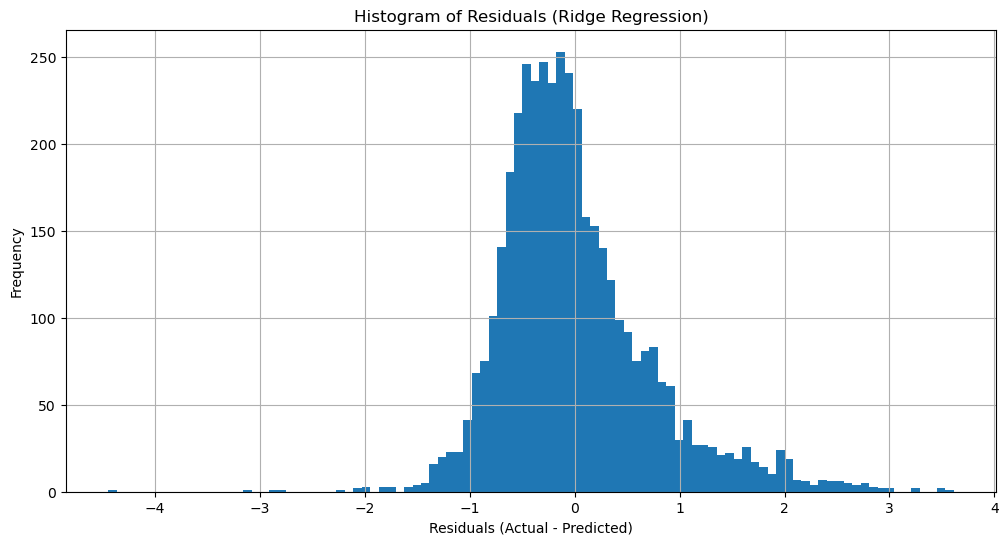

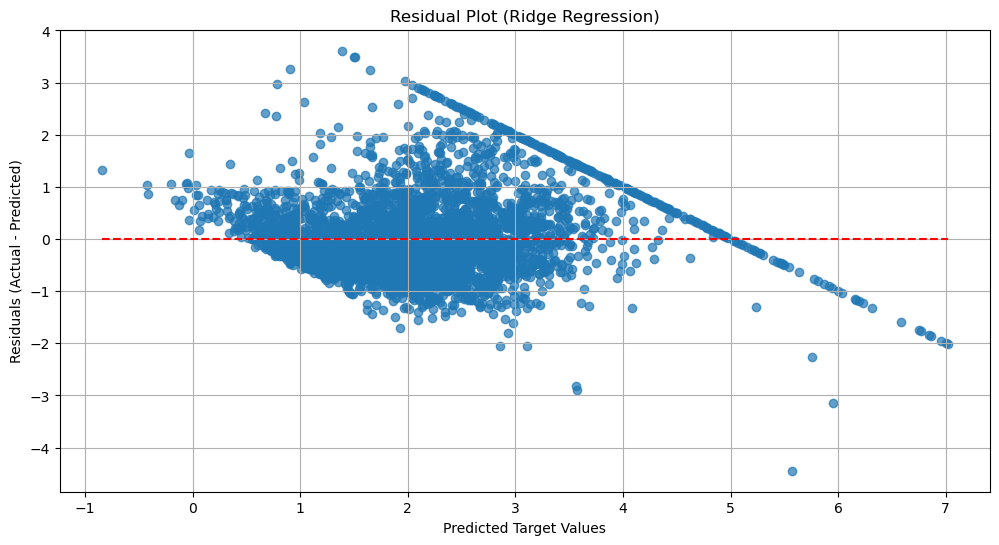

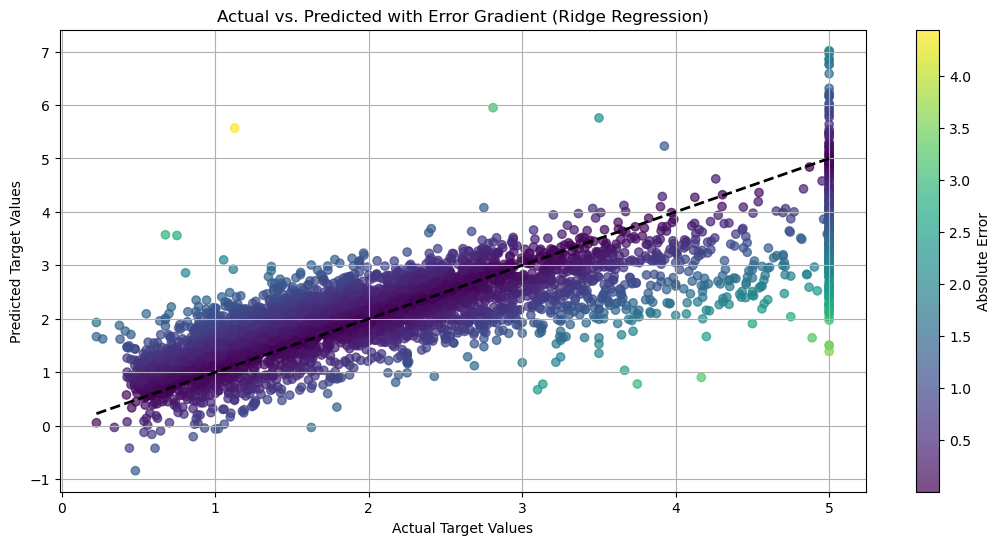

In [64]:
ridge_residuals = ridge_median_y_test - ridge_median_y_test_predictions

plt.figure(figsize = (12, 6))
plt.hist(ridge_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Ridge Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(ridge_median_y_test_predictions, ridge_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = ridge_median_y_test_predictions.min(), xmax = ridge_median_y_test_predictions.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Ridge Regression)')
plt.grid(True)
plt.show()

errors = abs(ridge_median_y_test - ridge_median_y_test_predictions) 
plt.figure(figsize = (13, 6))
plt.scatter(ridge_median_y_test, ridge_median_y_test_predictions, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([ridge_median_y_test.min(), ridge_median_y_test.max()], [ridge_median_y_test.min(), ridge_median_y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Ridge Regression)')
plt.grid(True)
plt.show()

#### Support Vector Model

In [65]:
svr_median_X_train = results["SVR"]["median_X_train"]
svr_median_y_train = results["SVR"]["median_y_train"]
svr_median_y_test = results["SVR"]["median_y_test"]
svr_median_y_test_predictions = results["SVR"]["median_y_test_predictions"]

svr_train_mse = results["SVR"]["median_train_mse"]
svr_mse = results["SVR"]["median_mse"]
svr_mae = results["SVR"]["median_mae"]
svr_r2 = results["SVR"]["median_r2"]
svr_adjusted_r2 = results["SVR"]["median_adjusted_r2"]

In [66]:
svr_train_mse_string = f"{train_mse_string}: {svr_train_mse}"
svr_mse_string = f"{mse_string}: {svr_mse}"
svr_mae_string = f"{mae_string}: {svr_mae}"
svr_r2_string = f"{r2_string}: {svr_r2}"
svr_adjusted_r2_string = f"{adjusted_r2_string}: {svr_adjusted_r2}"

print(svr_train_mse_string)
print(svr_mse_string)
print(svr_mae_string)
print(svr_r2_string)
print(svr_adjusted_r2_string)

Mean Squared Error on Training Set: 0.33848559585388077
Mean Squared Error on Testing Set: 0.33770670744147185
Mean Absolute Error on Testing Set: 0.386612214210005
R-Squared Score on Testing Set: 0.75279395425224
Adjusted R-Squared Score on Testing Set: 0.7523138259769349


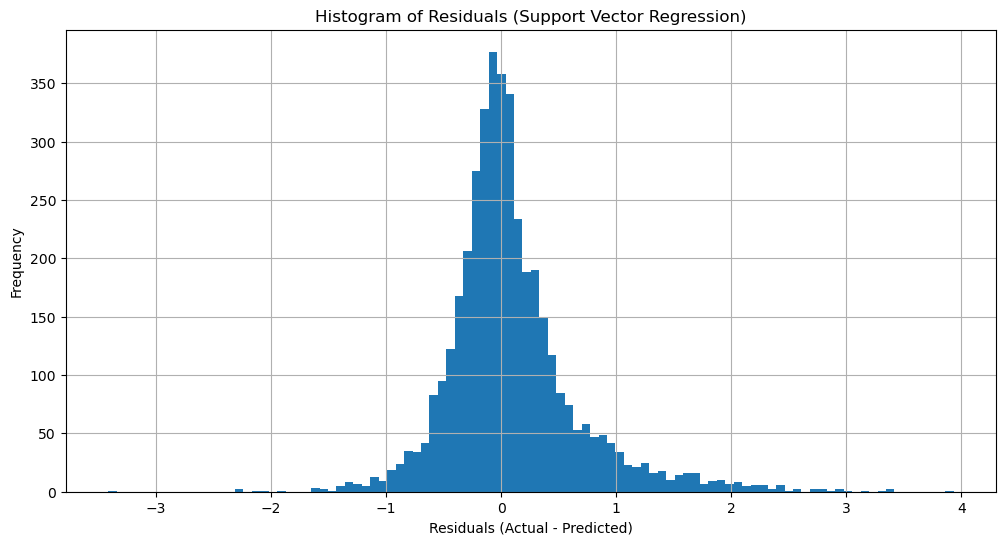

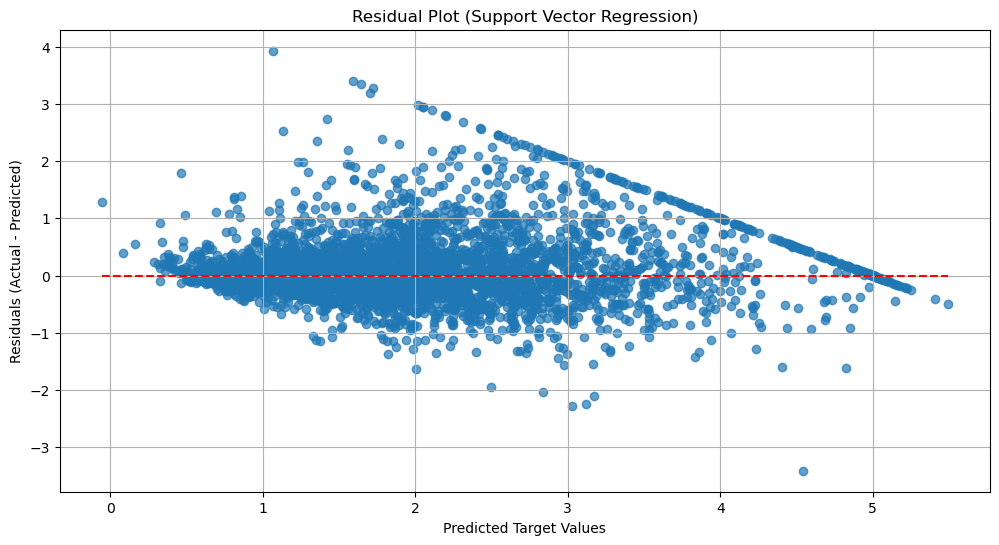

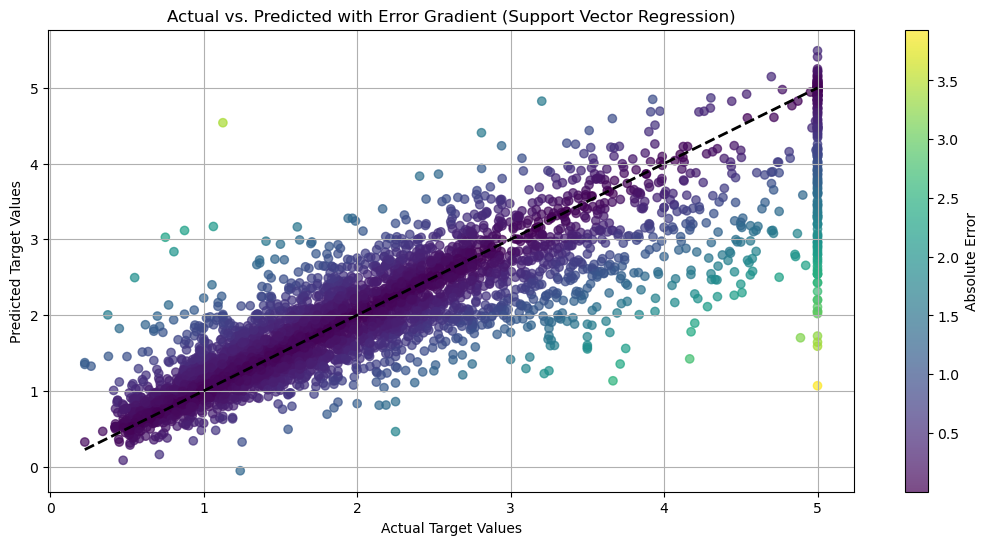

In [67]:
svr_residuals = svr_median_y_test - svr_median_y_test_predictions

plt.figure(figsize = (12, 6))
plt.hist(svr_residuals, bins = 100)  
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Support Vector Regression)')
plt.grid(True)
plt.show()

plt.figure(figsize = (12, 6))
plt.scatter(svr_median_y_test_predictions, svr_residuals, alpha = 0.7)
plt.hlines(y = 0, xmin = svr_median_y_test_predictions.min(), xmax = svr_median_y_test_predictions.max(), linestyles = 'dashed', colors = 'red')
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot (Support Vector Regression)')
plt.grid(True)
plt.show()

errors = abs(svr_median_y_test - svr_median_y_test_predictions) 
plt.figure(figsize = (13, 6))
plt.scatter(svr_median_y_test, svr_median_y_test_predictions, c = errors, cmap = 'viridis', alpha = .7)  
plt.colorbar(label='Absolute Error') 
plt.plot([svr_median_y_test.min(), svr_median_y_test.max()], [svr_median_y_test.min(), svr_median_y_test.max()], 'k--', lw = 2)  
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Actual vs. Predicted with Error Gradient (Support Vector Regression)')
plt.grid(True)
plt.show()

## Model Comparison

In [68]:

result_data = [
    [linear_train_mse, linear_mse, linear_mae, linear_r2, linear_adjusted_r2],
    [lasso_train_mse, lasso_mse, lasso_mae, lasso_r2, lasso_adjusted_r2],
    [ridge_train_mse, ridge_mse, ridge_mae, ridge_r2, ridge_adjusted_r2],
    [random_forest_train_mse, random_forest_mse, random_forest_mae, random_forest_r2, random_forest_adjusted_r2],
    [svr_train_mse, svr_mse, svr_mae, svr_r2, svr_adjusted_r2]
]

model_index = ['Linear', 'Lasso', 'Ridge', 'Random Forest', 'Support Vector']

results_df = pd.DataFrame(result_data, columns=['MSE on Training Set', 'MSE', 'MAE', 'R-squared', 'Adjusted R-squared'], index = model_index)
results_df

,MSE on Training Set,MSE,MAE,R-squared,Adjusted R-squared
Linear,0.523538,0.527280,0.536504,0.614024,0.613274
Lasso,0.529083,0.533928,0.540972,0.609158,0.608398
Ridge,0.523578,0.527360,0.536477,0.613965,0.613215
Random Forest,0.035828,0.035180,0.119922,0.974248,0.974198
Support Vector,0.338486,0.337707,0.386612,0.752794,0.752314


In [69]:
highest_r2_index = results_df["R-squared"].idxmax()
highest_r2_row = results_df.loc[highest_r2_index]

print(f"Reccomended Model based on R-squared Score (higher is better): {highest_r2_index}")


Reccomended Model based on R-squared Score (higher is better): Random Forest
